# Getting Started with JAX

## _JAX vs PyTorch_ - a Bad Framing for getting started

In this session, we'll explore the capabilities of JAX as a machine learning framework. A common starting point is to compare JAX with PyTorch, but it's not very helpful: PyTorch is an entire collection of packages for end-to-end ML model operationalisation, and JAX is.... not that.

So let's understand JAX on its own terms, and how with its extended tools it can make a great alternative for a machine learning system, especially in research science. To do this, we'll make the following, showing the potential and field around circular magnetic sources.

The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\phi = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\phi_i}.$$ A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) \propto -\nabla(\mathbf{m}\cdot\mathbf{r})$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it.

What is important for our tutorial is only the $-\nabla$ and $\sum$ operations: that is, **differentiation** and **vectorisation**.


![Magnetic scalar potential and field around finite dipole sources](source-field.png)

## Differentiation

JAX tries to be very good at a very small number of things. The first one is numerical differentiation. Here's a non-trivial example.

In [1]:
# Plotting style setup
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee"])

In [9]:
import jax
import jax.numpy as jnp


def _potential(m, r0, r, radius=1.0):
    """Dipole potential in two dimensions."""
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm <= radius
    interior = m_dot_r / radius / (2 * jnp.pi * radius)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)


def field(m, r0, r):
    """Dipole field in two dimensions."""
    return -jax.grad(_potential, argnums=0)(m, r0, r)

In [ ]:
config = {
    "n_samples": 1,
    "n_sources": 2,
    "seed": 43,
    "lim": 3,
    "res": 200,
}

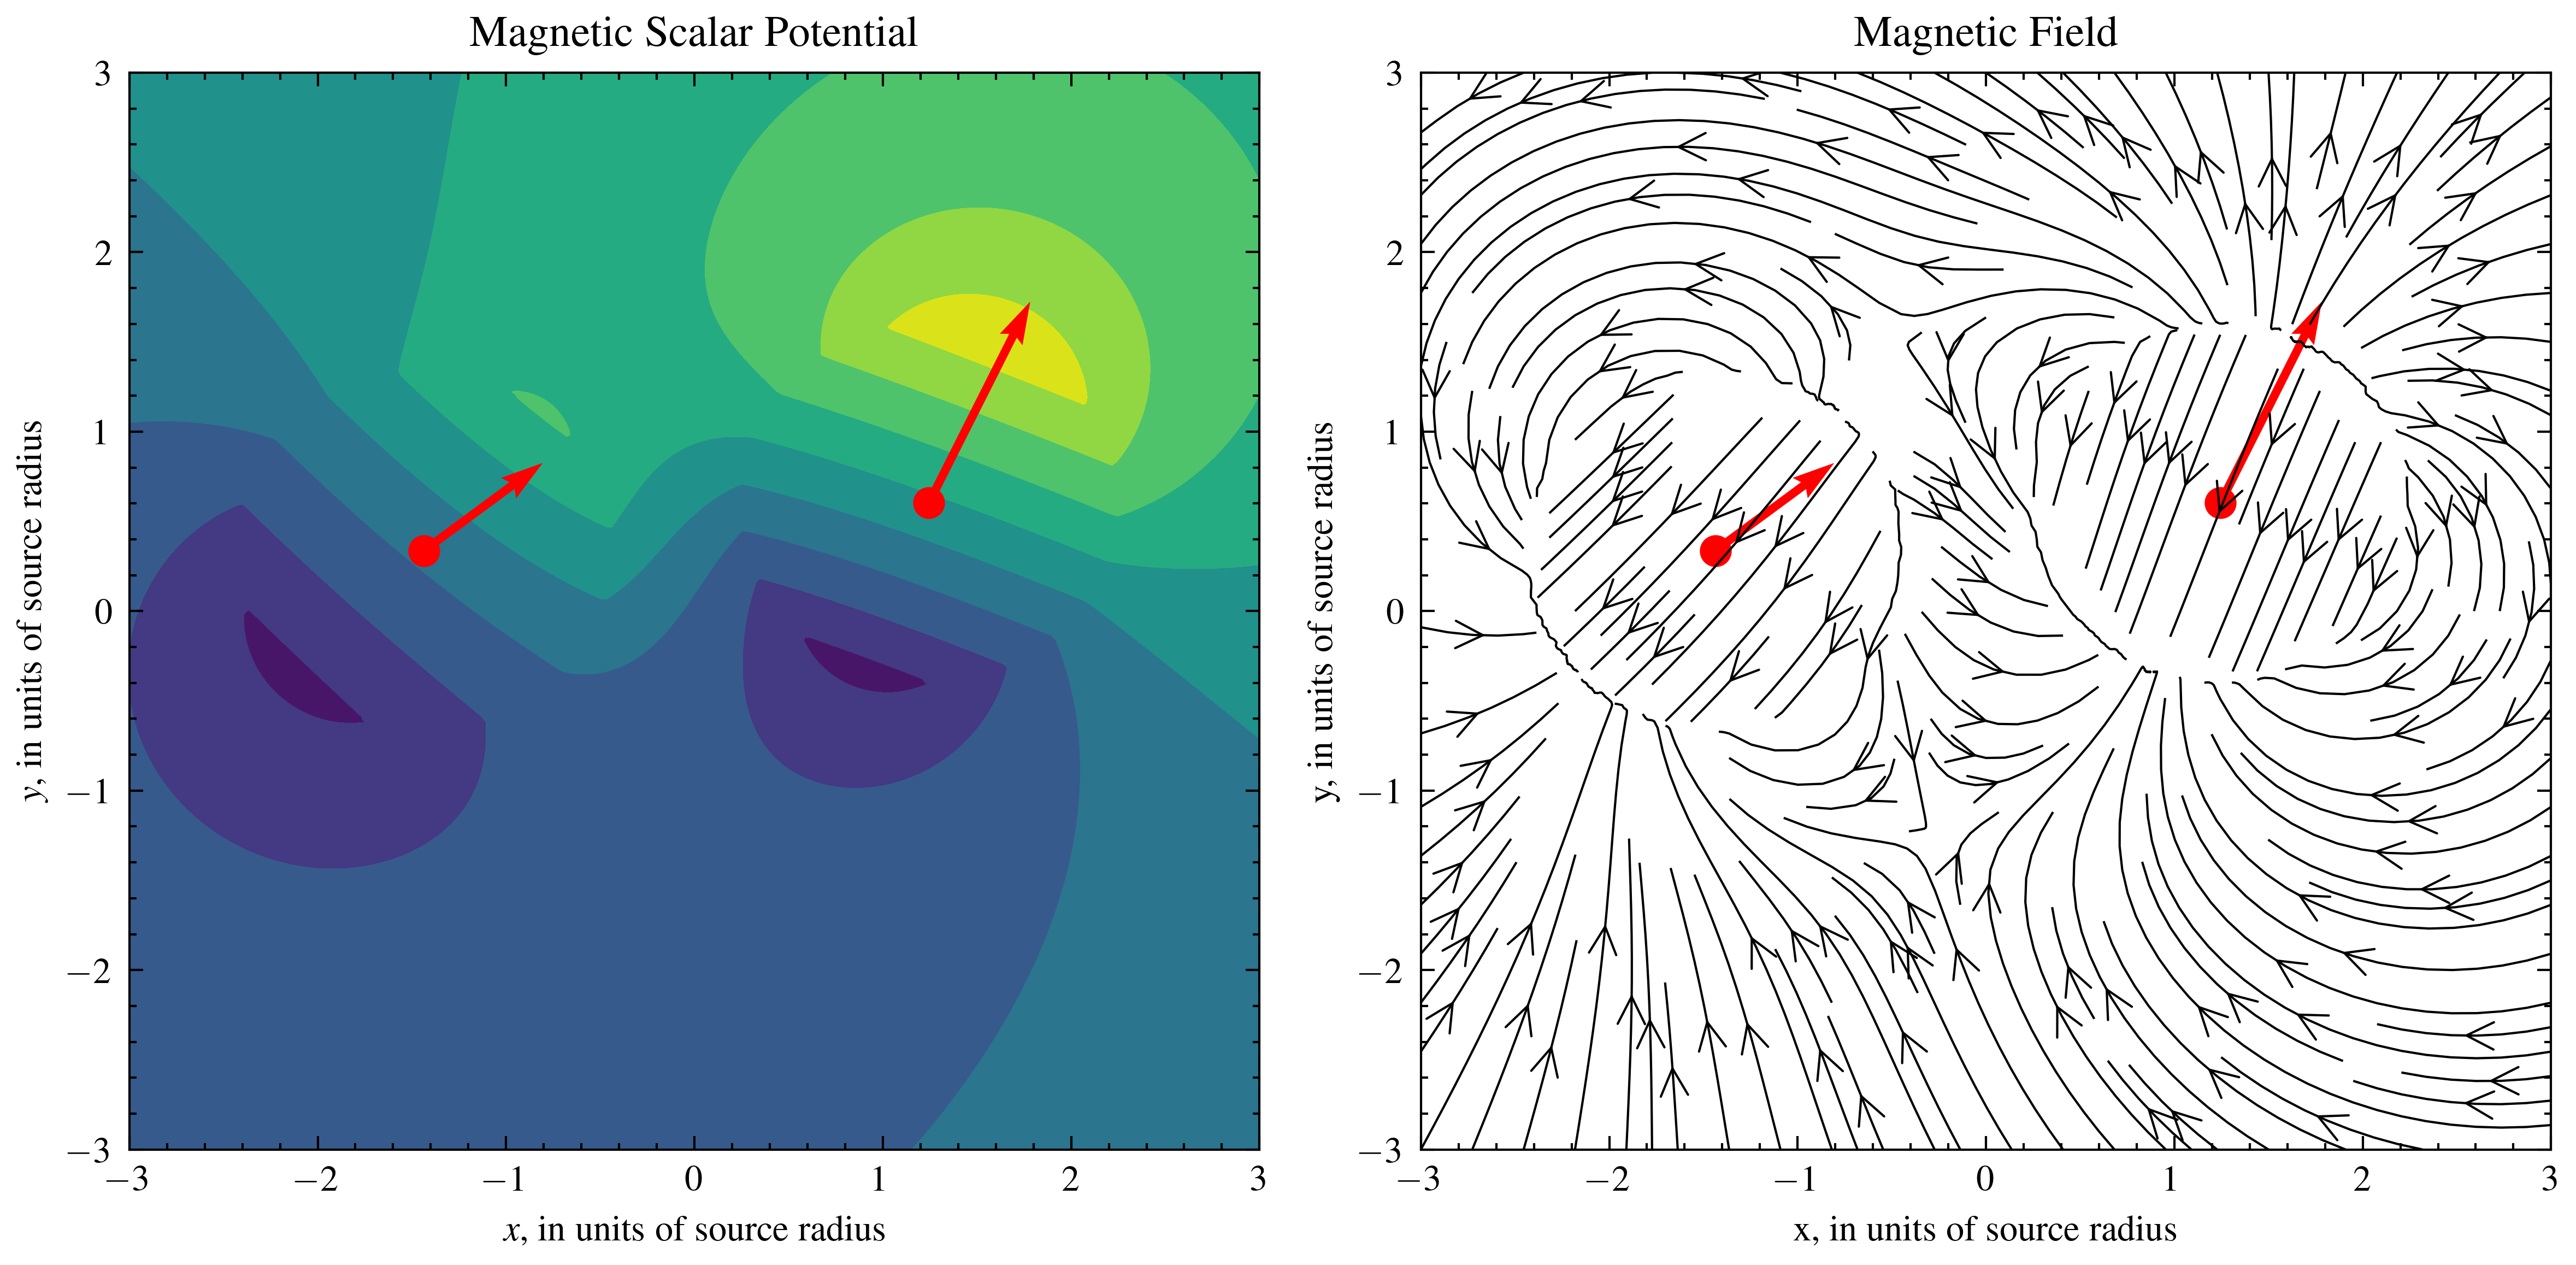

In [10]:
from hypermagnetics import plots

plots(configure(**config), model=None)

## 2. Vectorisation

JAX also promotes *vectorisation* as a way of rapidly applying a function to arrays of data. Unlike Numpy, JAX wants you to make this explicit: functions do not accept arrays, they accept scalars (like the mathematical functions we would write down on a page) and 

### Key Differences

- **Functional Programming Paradigm**: JAX encourages a functional programming style, offering a different approach to state and side-effects compared to PyTorch.
- **First-Class Automatic Differentiation**: JAX extends autodiff capabilities beyond what's commonly found in PyTorch, particularly with respect to functional transformations.
- **XLA Backend**: Leveraging XLA (Accelerated Linear Algebra) allows JAX to optimize and execute computations across a wide range of hardware efficiently.

### Why Not a Direct Comparison?

- **Different Design Philosophies**: While PyTorch emphasizes an imperative style with a dynamic computation graph, JAX is rooted in functional programming and static computation graphs.
- **Complementary, Not Competitive**: JAX isn't necessarily a replacement for PyTorch. It can be used in conjunction with PyTorch, especially in areas where JAX's functional style and autodiff capabilities shine.
- **Focus on Strengths**: For newcomers, understanding JAX's strengths, such as its performance in large-scale, high-performance computing environments, is more beneficial than a direct comparison with PyTorch.